In [1]:
import cv2
import numpy as np

In [2]:
import IPython.display as display
from PIL import Image
from io import BytesIO

def show_in_notebook(frame):
    """Converts a frame to an image and displays it inline in Jupyter."""
    _, encoded_img = cv2.imencode(".png", frame)
    img_bytes = BytesIO(encoded_img.tobytes())
    display.display(Image.open(img_bytes))

In [3]:
def get_zoomed_region(img, cX, cY, zoom_factor=2, output_size=(512, 512)):
    """Extracts and resizes a zoomed-in region centered at (cX, cY)."""
    h, w = img.shape[:2]
    
    # Define crop size (ensuring within bounds)
    crop_w, crop_h = w // (2 * zoom_factor), h // (2 * zoom_factor)
    x1, x2 = max(cX - crop_w, 0), min(cX + crop_w, w)
    y1, y2 = max(cY - crop_h, 0), min(cY + crop_h, h)

    # Crop the region and resize it to the output size
    cropped = img[y1:y2, x1:x2]
    zoomed = cv2.resize(cropped, output_size, interpolation=cv2.INTER_LINEAR)

    return zoomed

In [4]:
# Initialize video capture from file
vs = cv2.VideoCapture("./basketball.mp4")
if not vs.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the initial frame size
ret, frame = vs.read()
if not ret:
    print("Error: Could not read video file.")
    vs.release()
    exit()

In [5]:
# Initialize the motion saliency object
saliency = cv2.saliency.MotionSaliencyBinWangApr2014.create()
height, width = frame.shape[:2]
saliency.setImagesize(width, height)
saliency.init()

True

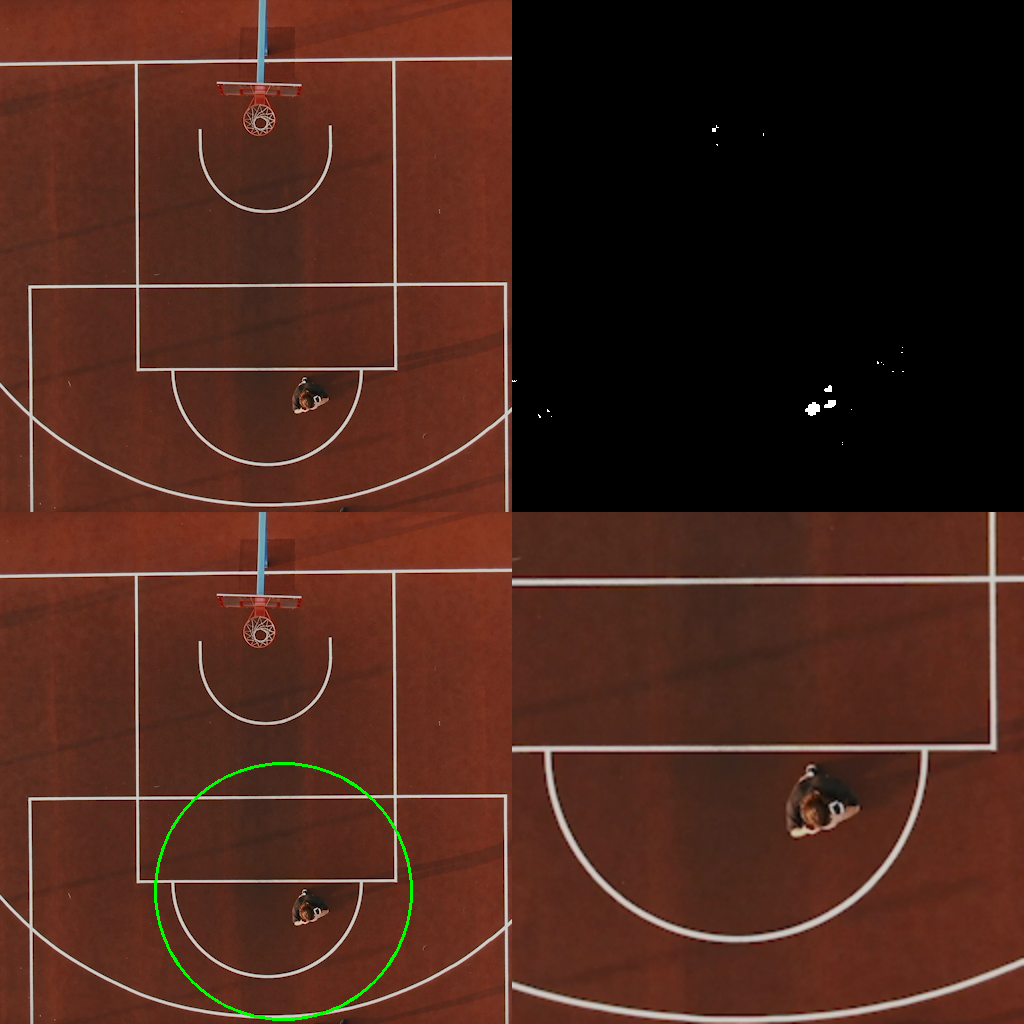

In [6]:
# Kernel size for Gaussian blur to reduce noise
BLUR_KERNEL = (25, 25)

while True:
    ret, frame = vs.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, BLUR_KERNEL, 0)

    success, saliencyMap = saliency.computeSaliency(gray)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    # Compute centroid
    M = cv2.moments(saliencyMap, binaryImage=True)
    if M["m00"] != 0:
        cX, cY = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
    else:
        cX, cY = None, None

    labeled_frame = frame.copy()
    
    if cX is not None and cY is not None:
        cv2.circle(labeled_frame, (cX, cY), 128, (0, 255, 0), 2)

        # Extract zoomed-in region around the centroid
        zoomed_frame = get_zoomed_region(frame, cX, cY, zoom_factor=2)
    else:
        zoomed_frame = np.zeros((512, 512, 3), dtype=np.uint8)  # Placeholder

    saliencyMap_color = cv2.cvtColor(saliencyMap, cv2.COLOR_GRAY2BGR)

    # Stack images in a 2x2 grid
    top_row = np.hstack((frame, saliencyMap_color))
    bottom_row = np.hstack((labeled_frame, zoomed_frame))
    grid = np.vstack((top_row, bottom_row))

    # Clear previous output and show the new frame
    display.clear_output(wait=True)
    show_in_notebook(grid)

vs.release()